In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

from sklearn.metrics import log_loss, mean_squared_error, accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import imageio

sns.set()

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

# Sigmoid Neuron

In [0]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)

  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      ValueError('y should be 0 or 1')

  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * 1
    elif y == 1:
      return -1 * (1 - y_pred) * 1
    else:
      ValueError('y should be 0 or 1')
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn='mse', display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0.0
      db = 0.0
      for x, y in zip(X, Y):
        if loss_fn == 'mse':
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y)       
        elif loss_fn == 'ce':
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)

      m = X.shape[1]
      self.w -= learning_rate * dw/m
      self.b -= learning_rate * db/m
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == 'mse':
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == 'ce':
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == 'mse':
        plt.ylabel('Mean Squared Error')
      elif loss_fn == 'ce':
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

# Generate Data

In [0]:
data, labels = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


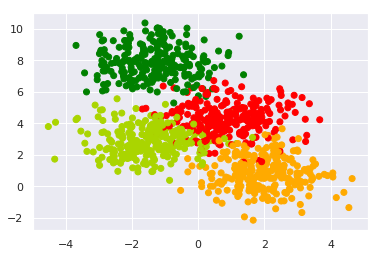

In [0]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [0]:
labels_orig = labels[:]
labels = np.mod(labels, 2)

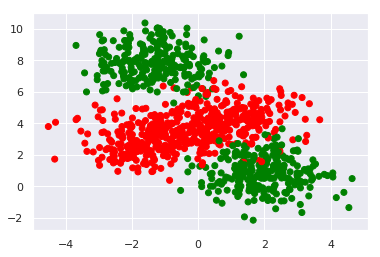

In [0]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape)

(750, 2) (250, 2)


# Train Sigmoid Neuron

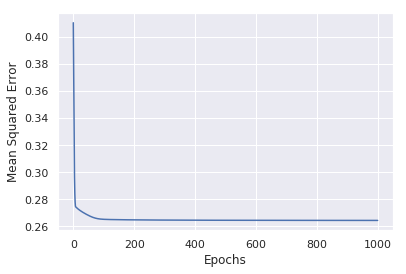

In [0]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, 1000, 0.1, True, 'mse', True)
# sn.fit(X_train, Y_train, 100, 0.0005, True, 'ce', True) # y_train is not binarised

In [0]:
y_train_pred = sn.predict(X_train)
y_train_pred_binarised = (y_train_pred >= 0.5).astype('int').ravel()
y_val_pred = sn.predict(X_val)
y_val_pred_binarised = (y_val_pred >= 0.5).astype('int').ravel()
print('Training Accuracy:', round(accuracy_score(Y_train, y_train_pred_binarised),2))
print('Validation Accuracy:', round(accuracy_score(Y_val, y_val_pred_binarised), 2))

Training Accuracy: 0.73
Validation Accuracy: 0.72


[]

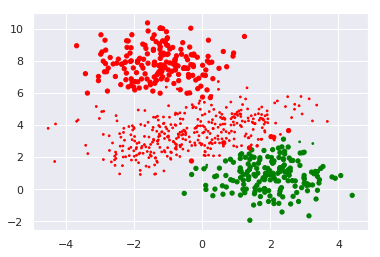

In [0]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train_pred_binarised, cmap=my_cmap, s=15*(np.abs(y_train_pred - Y_train) + 0.2))
plt.plot()

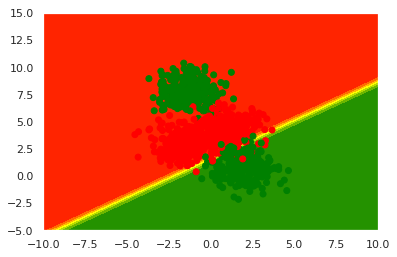

In [0]:
X1 = np.linspace(-10, 10, 100)
X2 = np.linspace(-5, 15, 100)

XX1, XX2 = np.meshgrid(X1, X2)
y_predicted = np.zeros(XX1.shape)

for i in range(X2.size):
  for j in range(X1.size):
    y_predicted[i,j] = sn.sigmoid(sn.perceptron(np.asarray([X1[j], X2[i]])))

plt.contourf(XX1, XX2, y_predicted, cmap=my_cmap)
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

# Feed Forward Network with only W1 updating with GD

In [0]:
class FirstFFNetworkW1:

  def __init__(self):
    self.w1 = np.random.randn()
    self.w2 = np.random.randn()
    self.w3 = np.random.randn()
    self.w4 = np.random.randn()
    self.w5 = np.random.randn()
    self.w6 = np.random.randn()
    self.b1 = 0
    self.b2 = 0
    self.b3 = 0

  def sigmoid(self, x):
    return 1/(1+np.exp(-x))
  
  def forward_pass(self, x):
    self.x1, self.x2 = x
    self.a1 = self.x1*self.w1 + self.x2*self.w2 + self.b1
    self.a2 = self.x1*self.w3 + self.x2*self.w4 + self.b2
    self.h1 = self.sigmoid(self.a1)
    self.h2 = self.sigmoid(self.a2)
    self.a3 = self.h1*self.w5 + self.h2*self.w6 + self.b3
    self.h3 = self.sigmoid(self.a3)
    return self.h3

  def grad(self,x,y):
    self.forward_pass(x)

    # self.dw5 = (self.h3-y) * self.h3 * (1 - self.h3) * self.h1
    # self.dw6 = (self.h3-y) * self.h3 * (1 - self.h3) * self.h2
    # self.db3 = (self.h3-y) * self.h3 * (1 - self.h3)

    self.dw1 = (self.h3-y) * self.h3 * (1-self.h3) * self.w5 * self.h1 * (1 - self.h1) * self.x1
    # self.dw2 = (self.h3-y) * self.h3 * (1-self.h3) * self.w5 * self.h1 * (1 - self.h1) * self.x2
    # self.db1 = (self.h3-y) * self.h3 * (1-self.h3) * self.w5 * self.h1 * (1 - self.h1)

    # self.dw3 = (self.h3-y) * self.h3 * (1-self.h3) * self.w6 * self.h2 * (1 - self.h2) * self.x1
    # self.dw4 = (self.h3-y) * self.h3 * (1-self.h3) * self.w6 * self.h2 * (1 - self.h2) * self.x2
    # self.db2 = (self.h3-y) * self.h3 * (1-self.h3) * self.w6 * self.h2 * (1 - self.h2) 

  def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss=False):

    if initialize:
      self.w1 = np.random.randn()
      self.w2 = np.random.randn()
      self.w3 = np.random.randn()
      self.w4 = np.random.randn()
      self.w5 = np.random.randn()
      self.w6 = np.random.randn()
      self.b1 = 0
      self.b2 = 0
      self.b3 = 0
    
    if display_loss:
      W1 = {}
      loss = {}
      h1 = {}
      h3 = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      dw1, dh1, dh3 = [0]*3
      for x,y in zip(X,Y):
        self.grad(x,y)
        dw1 += self.dw1
        dh3 += (self.h3-y) * self.h3 * (1-self.h3) #self.h1
        dh1 += self.w5 * self.h1 * (1 - self.h1) * self.x1 #self.h3
        # dw2 += self.dw2
        # dw3 += self.dw3
        # dw4 += self.dw4
        # dw5 += self.dw5
        # dw6 += self.dw6
        # db1 += self.db1
        # db2 += self.db2
        # db3 += self.db3
      
      m = X.shape[0]
      self.w1 -= learning_rate*dw1/m
      # dh1 = dh1/m
      # dh3 = dh3/m
      # self.w2 -= learning_rate*dw2/m
      # self.w3 -= learning_rate*dw3/m
      # self.w4 -= learning_rate*dw4/m
      # self.w5 -= learning_rate*dw5/m
      # self.w6 -= learning_rate*dw6/m
      # self.b1 -= learning_rate*db1/m
      # self.b2 -= learning_rate*db2/m
      # self.b3 -= learning_rate*db3/m

      if display_loss:
        W1[i] = dw1 #self.w1
        Y_pred = self.predict(X)
        loss[i] = mean_squared_error(Y_pred, Y)
        h1[i] = dh1
        h3[i] = dh3

    if display_loss:
      plt.tight_layout()

      plt.subplot(4,1,1)
      plt.plot(W1.values())
      plt.xlabel('epochs')
      plt.ylabel('W1')

      plt.subplot(4, 1, 2)
      plt.plot(h1.values())
      plt.xlabel('Epochs')
      plt.ylabel('h1')
      
      plt.subplot(4, 1, 3)
      plt.plot(h3.values())
      plt.xlabel('Epochs')
      plt.ylabel('h3')

      plt.subplot(4,1,4)
      plt.plot(loss.values())
      plt.xlabel('epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()

  def predict(self, X):
    y_pred = []
    for x in X:
      y_pred.append(self.forward_pass(x))
    return np.asarray(y_pred)

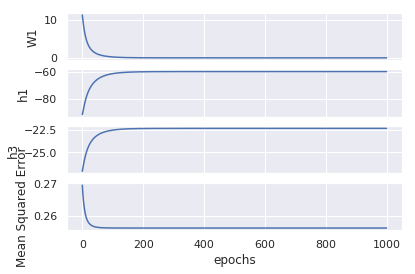

In [0]:
ffn = FirstFFNetworkW1()
ffn.fit(X_train, Y_train, 1000, 4, True, True)

# Feed Forward Network Class

In [0]:
class FirstFFNetwork:

  def __init__(self):
    self.w1 = np.random.randn()
    self.w2 = np.random.randn()
    self.w3 = np.random.randn()
    self.w4 = np.random.randn()
    self.w5 = np.random.randn()
    self.w6 = np.random.randn()
    self.b1 = 0
    self.b2 = 0
    self.b3 = 0

  def sigmoid(self, x):
    return 1/(1+np.exp(-x))
  
  def forward_pass(self, x):
    self.x1, self.x2 = x
    self.a1 = self.x1*self.w1 + self.x2*self.w2 + self.b1
    self.a2 = self.x1*self.w3 + self.x2*self.w4 + self.b2
    self.h1 = self.sigmoid(self.a1)
    self.h2 = self.sigmoid(self.a2)
    self.a3 = self.h1*self.w5 + self.h2*self.w6 + self.b3
    self.h3 = self.sigmoid(self.a3)
    return self.h3

  def grad(self,x,y):
    self.forward_pass(x)

    self.dw5 = (self.h3-y) * self.h3 * (1 - self.h3) * self.h1
    self.dw6 = (self.h3-y) * self.h3 * (1 - self.h3) * self.h2
    self.db3 = (self.h3-y) * self.h3 * (1 - self.h3)

    self.dw1 = (self.h3-y) * self.h3 * (1-self.h3) * self.w5 * self.h1 * (1 - self.h1) * self.x1
    self.dw2 = (self.h3-y) * self.h3 * (1-self.h3) * self.w5 * self.h1 * (1 - self.h1) * self.x2
    self.db1 = (self.h3-y) * self.h3 * (1-self.h3) * self.w5 * self.h1 * (1 - self.h1)

    self.dw3 = (self.h3-y) * self.h3 * (1-self.h3) * self.w6 * self.h2 * (1 - self.h2) * self.x1
    self.dw4 = (self.h3-y) * self.h3 * (1-self.h3) * self.w6 * self.h2 * (1 - self.h2) * self.x2
    self.db2 = (self.h3-y) * self.h3 * (1-self.h3) * self.w6 * self.h2 * (1 - self.h2) 

  def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss=False, display_weights=True):

    if initialize:
      self.w1 = np.random.randn()
      self.w2 = np.random.randn()
      self.w3 = np.random.randn()
      self.w4 = np.random.randn()
      self.w5 = np.random.randn()
      self.w6 = np.random.randn()
      self.b1 = 0
      self.b2 = 0
      self.b3 = 0
    
    if display_loss:
      loss = {}
    
    if display_weights:
      weights = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      dw1, dw2, dw3, dw4, dw5, dw6, db1, db2, db3 = [0]*9
      for x,y in zip(X,Y):
        self.grad(x,y)
        dw1 += self.dw1
        dw2 += self.dw2
        dw3 += self.dw3
        dw4 += self.dw4
        dw5 += self.dw5
        dw6 += self.dw6
        db1 += self.db1
        db2 += self.db2
        db3 += self.db3
      
      m = X.shape[0]
      self.w1 -= learning_rate*dw1/m
      self.w2 -= learning_rate*dw2/m
      self.w3 -= learning_rate*dw3/m
      self.w4 -= learning_rate*dw4/m
      self.w5 -= learning_rate*dw5/m
      self.w6 -= learning_rate*dw6/m
      self.b1 -= learning_rate*db1/m
      self.b2 -= learning_rate*db2/m
      self.b3 -= learning_rate*db3/m

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = mean_squared_error(Y_pred, Y)
      
      if display_weights:
        weights= np.asarray([[0, self.b3, self.w5, self.w6, 0, 0], [self.b1, self.w1, self.w2, self.w3, self.w4, self.b2]])
        weight_matrices.append(weights)

    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()

  def predict(self, X):
    y_pred = []
    for x in X:
      y_pred.append(self.forward_pass(x))
    return np.asarray(y_pred)
  
  def predict_h1(self, X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.h1)
    return np.asarray(y_pred)
  
  def predict_h2(self, X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.h2)
    return np.asarray(y_pred)
  
  def predict_h3(self, X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.h3)
    return np.asarray(y_pred)


# FF Network Classification

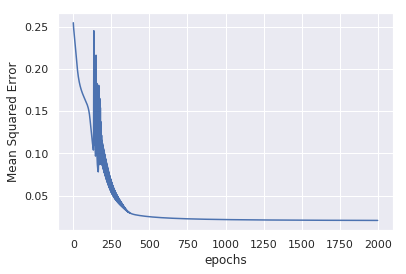

In [0]:
weight_matrices = []
fn = FirstFFNetwork()
fn.fit(X_train, Y_train, 2000, 5, True, True)

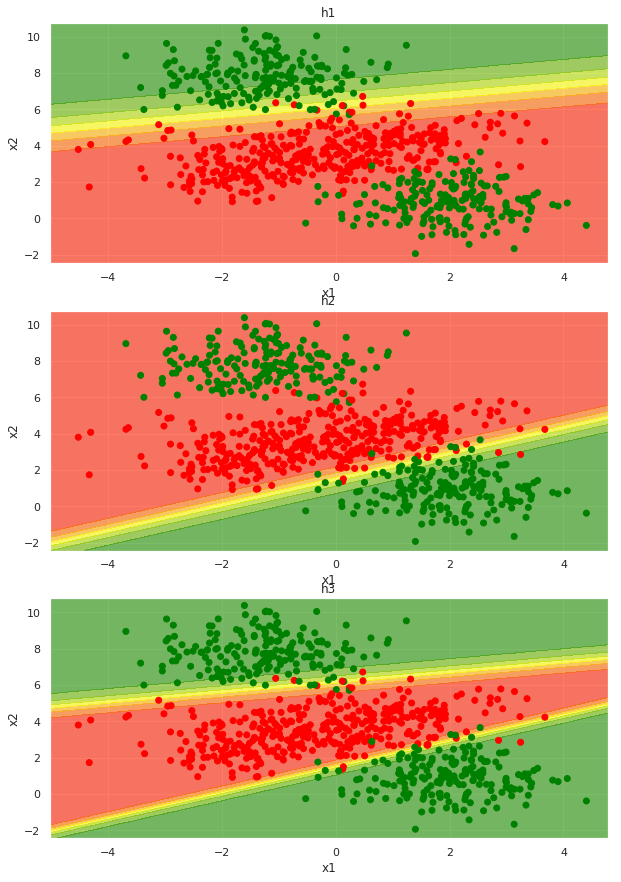

In [0]:
def make_meshgrid(step=0.2):
  x = [X_train[:,0].min() - 0.5, X_train[:,0].max() + 0.5]
  y = [X_train[:,1].min() - 0.5, X_train[:,1].max() + 0.5]

  xx, yy = np.meshgrid(np.arange(min(x), max(x), step), np.arange(min(y), max(y), step))
  return xx, yy

def plot_contour(ax, predict, xx, yy):
  output = predict(np.c_[xx.ravel(), yy.ravel()])
  output = output.reshape(xx.shape)
  ax.contourf(xx, yy, output, cmap=my_cmap, alpha=0.6)

def plot_boundaries():
  xx, yy = make_meshgrid(0.2)
  predict_functions = [fn.predict_h1, fn.predict_h2, fn.predict_h3]

  fig, ax = plt.subplots(3, figsize=(10,15))

  for i in range(3):

    plot_contour(ax[i], predict_functions[i], xx, yy)

    ax[i].scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
    ax[i].set_xlim(xx.min(), xx.max())
    ax[i].set_ylim(yy.min(), yy.max())
    ax[i].set_xlabel('x1')
    ax[i].set_ylabel('x2')
    ax[i].set_title('h' + str(i+1))

plot_boundaries()

In [0]:
def plot_heat_map(epoch):
  fig = plt.figure(figsize=(10,1))
  sns.heatmap(weight_matrices[epoch], vmin=-1, vmax=3, cmap=my_cmap, annot=True)
  plt.title("Epoch: "+str(epoch))

  fig.canvas.draw()
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
  image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

  return image

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


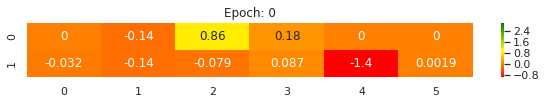

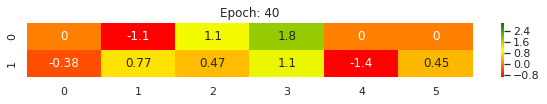

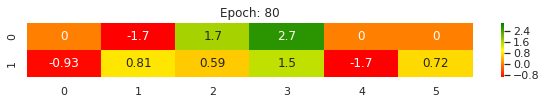

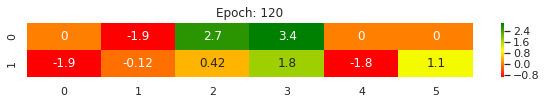

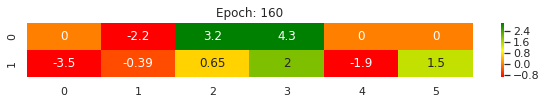

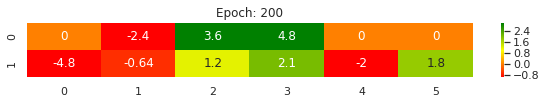

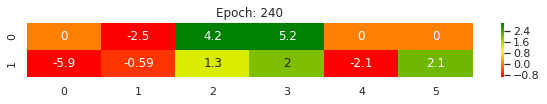

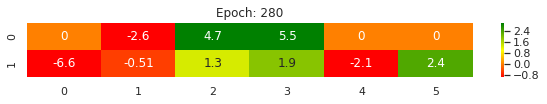

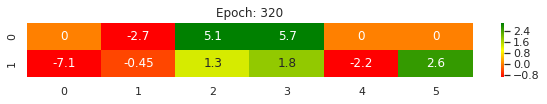

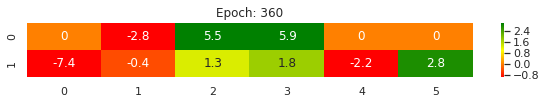

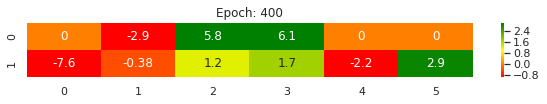

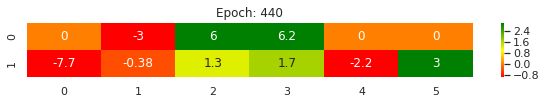

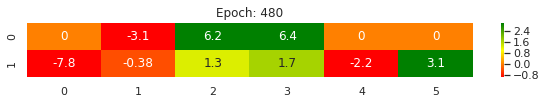

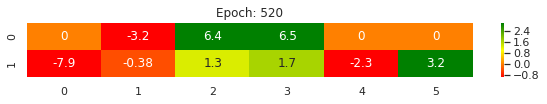

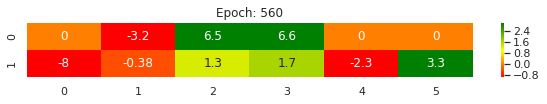

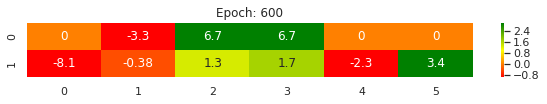

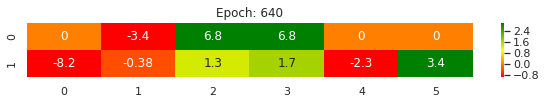

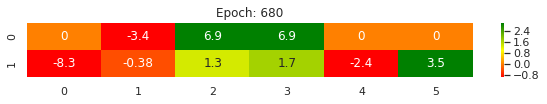

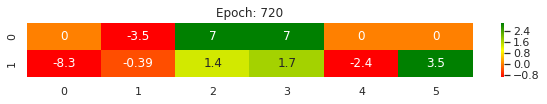

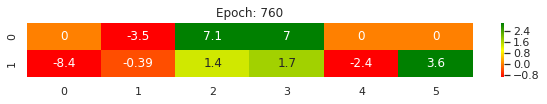

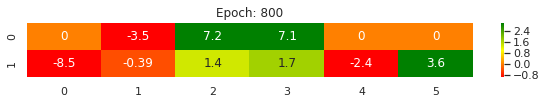

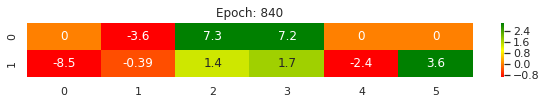

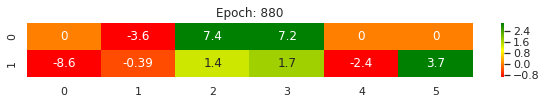

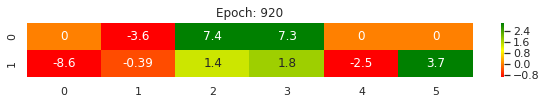

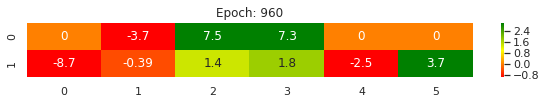

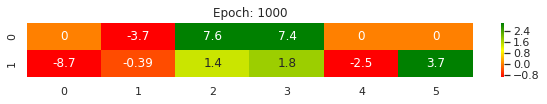

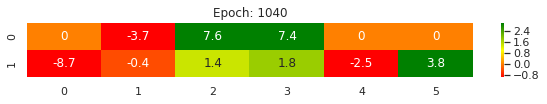

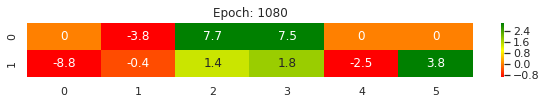

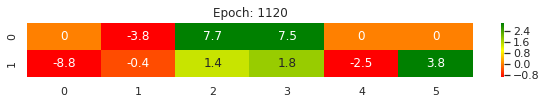

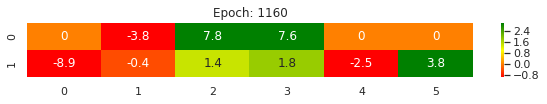

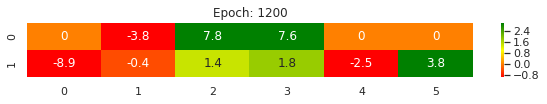

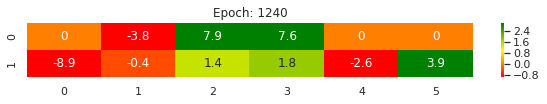

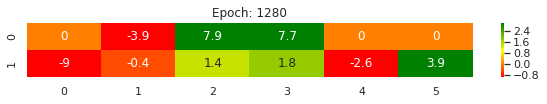

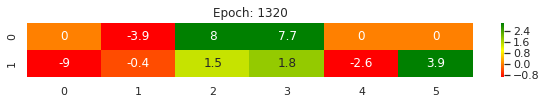

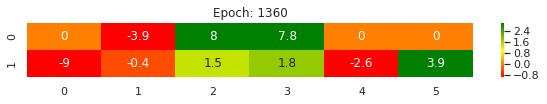

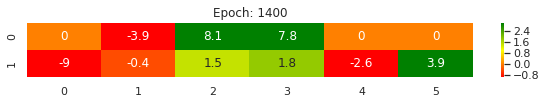

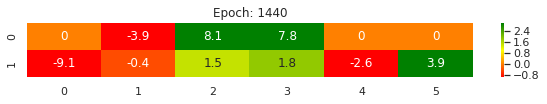

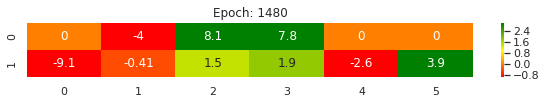

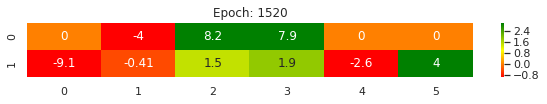

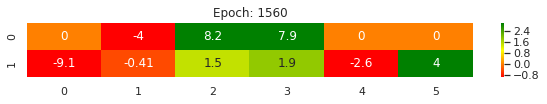

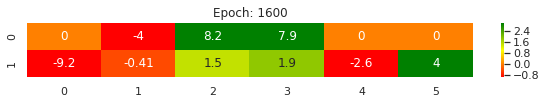

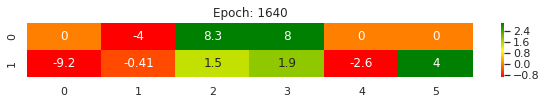

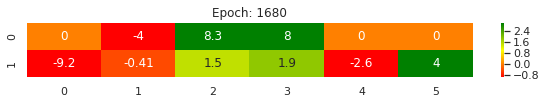

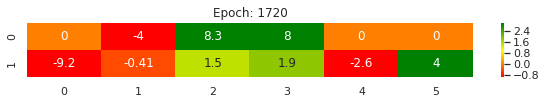

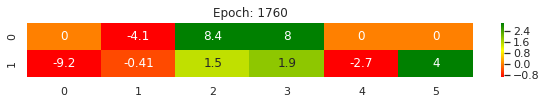

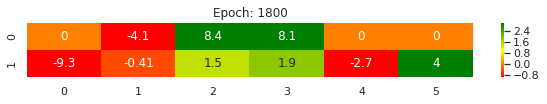

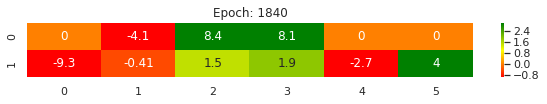

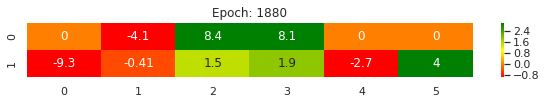

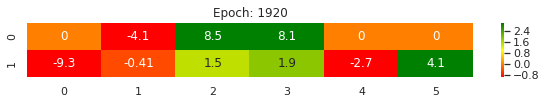

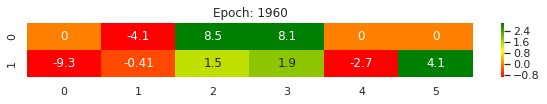

In [0]:
imageio.mimsave('./weights_viz.gif', [plot_heat_map(i) for i in range(0,len(weight_matrices),len(weight_matrices)//50)], fps=1)

In [0]:
y_train_pred = fn.predict(X_train)
y_train_pred_binarised = (y_train_pred >= 0.5).astype('int').ravel()
y_val_pred = fn.predict(X_val)
y_val_pred_binarised = (y_val_pred >= 0.5).astype('int').ravel()
print('Training Accuracy:', round(accuracy_score(Y_train, y_train_pred_binarised),2))
print('Validation Accuracy:', round(accuracy_score(Y_val, y_val_pred_binarised), 2))

Training Accuracy: 0.97
Validation Accuracy: 0.94


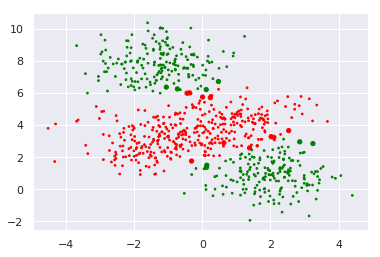

In [0]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train_pred_binarised, cmap=my_cmap, s=15*(np.abs(y_train_pred_binarised - Y_train) + 0.2))
plt.show()

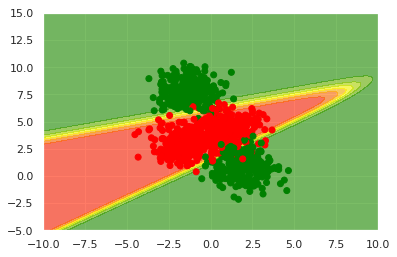

In [0]:
X1 = np.linspace(-10, 10, 100)
X2 = np.linspace(-5, 15, 100)

XX1, XX2 = np.meshgrid(X1, X2)
y_predicted = np.zeros(XX1.shape)

for i in range(X2.size):
  for j in range(X1.size):
    y_predicted[i,j] = fn.forward_pass(np.asarray([X1[j], X2[i]]))

plt.contourf(XX1, XX2, y_predicted, cmap=my_cmap, alpha=0.6)
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

# Feed Forward Network Generalised

In [0]:
class FFSNNetwork:

  def __init__(self, n_inputs, hidden_sizes=[2]):
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]

    self.W = {}
    self.B = {}

    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))

  def sigmoid(self, z):
    return 1/(1 + np.exp(-z))
  
  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]

  def grad_sigmoid(self, x):
    return x*(1-x)

  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k]= np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))

  def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss=False):

    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))

    if display_loss:
      loss = {}

    for e in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x,y in zip(X,Y):
        self.grad(x,y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
      
      m = X.shape[0]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1] / m
        self.B[i+1] -= learning_rate * dB[i+1] / m
      
      if display_loss:
        loss[e] = mean_squared_error(self.predict(X), Y)
      
    if display_loss:
      # print(loss)
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
  
  def predict(self, X):
    y_pred = []
    for x in X:
      y_pred.append(self.forward_pass(x))
    return np.asarray(y_pred).squeeze()
  
  def calculate_loss(self, X, Y):
    return mean_squared_error(self.predict(X), Y)


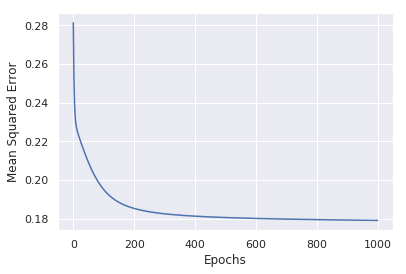

In [0]:
ffssn = FFSNNetwork(2, [2, 3])
ffssn.fit(X_train, Y_train, 1000, 0.001, display_loss=True)

In [0]:
y_pred_train = ffssn.predict(X_train)
y_pred_train_binarised = (y_pred_train >= 0.5)
y_pred_val = ffssn.predict(X_val)
y_pred_val_binarised = (y_pred_val >= 0.5)

print('Training Accuracy: ', round(accuracy_score(y_pred_train_binarised, Y_train), 2))
print('Validation Accuracy: ', round(accuracy_score(y_pred_val_binarised, Y_val),2))

Training Accuracy:  0.73
Validation Accuracy:  0.72


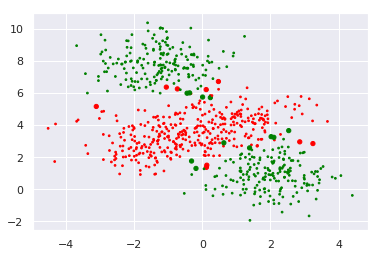

In [0]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap, s=15*(np.abs(y_pred_train_binarised - Y_train) + 0.2))
plt.show()

[]

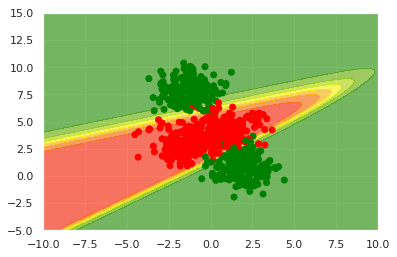

In [0]:
X1 = np.linspace(-10, 10, 100)
X2 = np.linspace(-5, 15, 100)

XX1, XX2 = np.meshgrid(X1, X2)
y_pred = np.zeros((XX1.shape))

for i in range(X2.size):
  for j in range(X1.size):
    y_pred[i, j] = ffssn.predict(np.asarray([X1[j], X2[i]]).reshape(1, -1))

plt.contourf(XX1, XX2, y_pred, cmap=my_cmap, alpha=0.6)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
plt.plot()

# Multi-class Classification

In [0]:
class FFSN_MultiClass:

  def __init__(self, n_inputs, n_outputs, hidden_sizes=[2]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]

    self.W = {}
    self.B = {}

    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))

  def sigmoid(self, z):
    return 1/(1 + np.exp(-z))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps/np.sum(exps)
  
  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]

  def cross_entropy(self, label, pred):
    y1 = np.multiply(label, pred)
    y1 = y1[y1!=0]
    y1 = -np.log(y1)
    y1 = np.mean(y1)
    return y1

  def grad_sigmoid(self, x):
    return x*(1-x)

  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k]= np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))

  def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss=False):

    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))

    if display_loss:
      loss = {}

    for e in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x,y in zip(X,Y):
        self.grad(x,y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
      
      m = X.shape[0]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1] / m
        self.B[i+1] -= learning_rate * dB[i+1] / m
      
      if display_loss:
        loss[e] = self.cross_entropy(self.predict(X), Y)
      
    if display_loss:
      # print(loss)
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
  
  def predict(self, X):
    y_pred = []
    for x in X:
      y_pred.append(self.forward_pass(x))
    return np.asarray(y_pred).squeeze()
  
  def predict_h1(self,X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.H[1][0,0])
    return np.asarray(y_pred).squeeze()

  def predict_h2(self,X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.H[1][0,1])
    return np.asarray(y_pred).squeeze()

  def predict_h3(self,X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.H[2][0,0])
    return np.asarray(y_pred).squeeze()

  def predict_h4(self,X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.H[2][0,1])
    return np.asarray(y_pred).squeeze()

  def predict_h5(self,X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.H[2][0,2])
    return np.asarray(y_pred).squeeze()

  def predict_h6(self,X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.H[3][0,0])
    return np.asarray(y_pred).squeeze()
  
  def predict_h7(self,X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.H[3][0,1])
    return np.asarray(y_pred).squeeze()

  def predict_h8(self,X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.H[3][0,2])
    return np.asarray(y_pred).squeeze()

  def predict_h9(self,X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.H[3][0,3])
    return np.asarray(y_pred).squeeze()

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [0]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train, axis=1)).toarray()
y_OH_val = enc.transform(np.expand_dims(Y_val, axis=1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


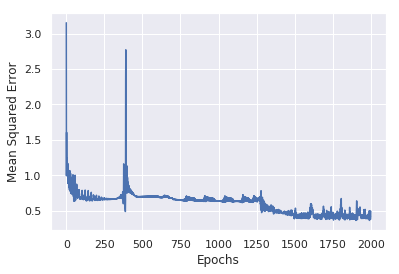

In [0]:
ffsn_multi = FFSN_MultiClass(2,4,[2,3])
ffsn_multi.fit(X_train, y_OH_train, 2000, 7, display_loss=True)

In [0]:
y_pred_train = ffsn_multi.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)

y_pred_val = ffsn_multi.predict(X_val)
y_pred_val = np.argmax(y_pred_val, axis=1)

print('Training Accuracy: ', round(accuracy_score(y_pred_train, Y_train),2))
print('Validation Accuracy: ', round(accuracy_score(y_pred_val, Y_val),2))

Training Accuracy:  0.89
Validation Accuracy:  0.88


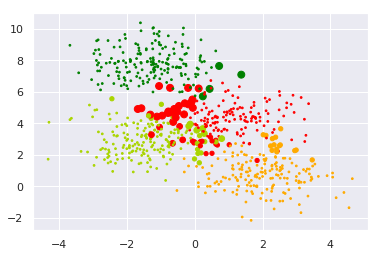

In [0]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap, s=15*(np.abs(y_pred_train - Y_train) + 0.2))
plt.show()

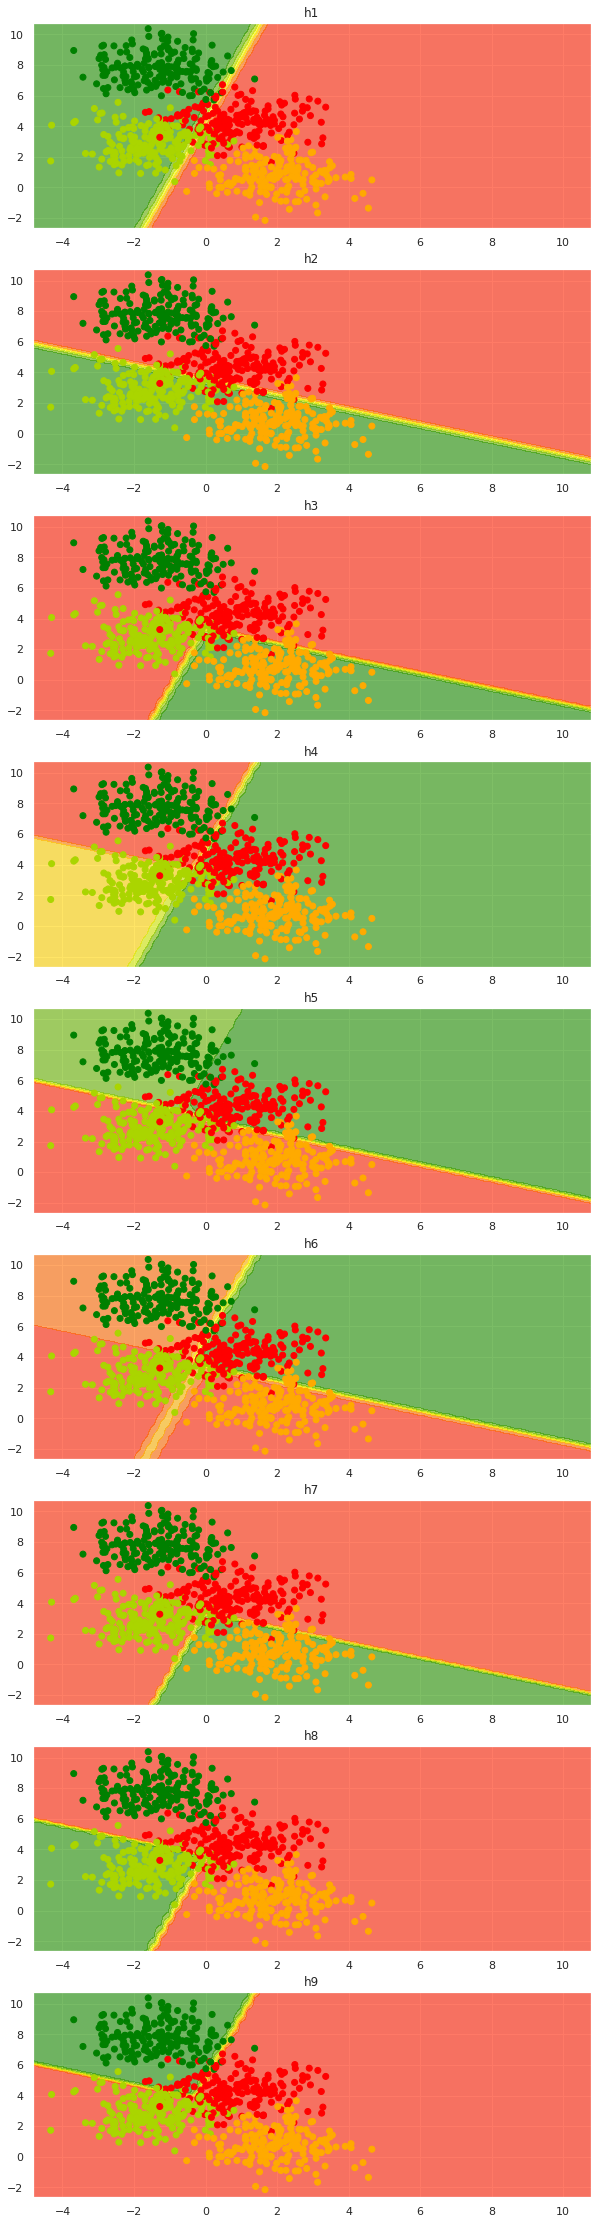

In [0]:
def make_meshgrid(step=0.2):
  x1 = [X_train[:,0].min() - 0.5, X_train[:,0].max() + 0.5]
  x2 = [X_train[:,1].min() - 0.5, X_train[:,1].max() + 0.5]

  xx, yy = np.meshgrid(np.arange(min(x1), max(x2), step), np.arange(min(x2), max(x2), step))
  return xx, yy

def plot_contour_maps(ax, predict, xx, yy):
  output = (predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
  
  ax.contourf(xx, yy, output, cmap=my_cmap, alpha=0.6)

def plot_decision_boundaries():
  xx, yy = make_meshgrid()
  predict = [ffsn_multi.predict_h1, ffsn_multi.predict_h2, ffsn_multi.predict_h3, ffsn_multi.predict_h4, ffsn_multi.predict_h5, ffsn_multi.predict_h6, ffsn_multi.predict_h7, ffsn_multi.predict_h8, ffsn_multi.predict_h9]

  fig, ax = plt.subplots(9, figsize=(10,40))

  for i in range(9):
    plot_contour_maps(ax[i], predict[i], xx, yy)

    ax[i].scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
    ax[i].set_title('h'+str(i+1))

plot_decision_boundaries()

In [0]:
print('Input<->H1', ffsn_multi.W[1])
print('H1<->H2', ffsn_multi.W[2])
print('H2<->Output', ffsn_multi.W[3])

Input<->H1 [[-9.03277655 -3.93617952]
 [ 2.20018956 -8.06224311]]
H1<->H2 [[-12.95992143  -8.07789651  -3.21909578]
 [  8.10808902   1.82647753  -7.85676621]]
H2<->Output [[-2.23376712  7.36163117 -6.83462537 -3.50098656]
 [ 4.43257372  7.09670844 -0.46542294 -7.07802354]
 [ 3.27080584  1.26015361 -7.88277282  6.68869327]]


# Exercise

## Moons Dataset

In [0]:
data_moons, Y_moons = make_moons(n_samples=1000, noise=0.15, random_state=0)
print(data_moons.shape, Y_moons.shape)

(1000, 2) (1000,)


[]

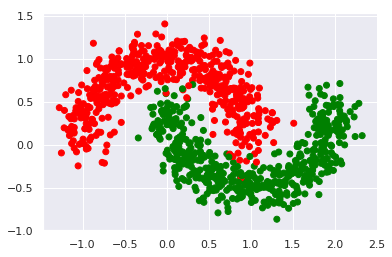

In [0]:
plt.scatter(data_moons[:,0], data_moons[:,1], c=Y_moons, cmap=my_cmap)
plt.plot()

In [0]:
X_train, X_test, Y_train, Y_val = train_test_split(data_moons, Y_moons, stratify=Y_moons, random_state=0)
print(X_train.shape, X_test.shape)

(750, 2) (250, 2)


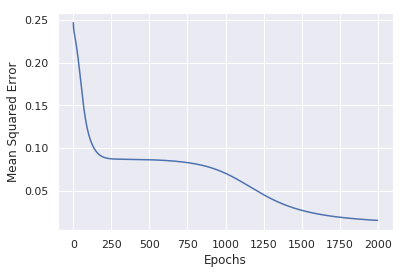

In [0]:
ffssn = FFSNNetwork(2, [8,8])
ffssn.fit(X_train, Y_train, 2000, 0.001, True, True)

In [0]:
y_pred_train = ffssn.predict(X_train)
y_pred_train_binarised = (y_pred_train >= 0.5)
y_pred_val = ffssn.predict(X_val)
y_pred_val_binarised = (y_pred_val >= 0.5)

print('Training Accuracy: ', accuracy_score(y_pred_train_binarised, Y_train))
print('Validation Accuracy: ', accuracy_score(y_pred_val_binarised, Y_val))

Training Accuracy:  0.9786666666666667
Validation Accuracy:  0.96


[]

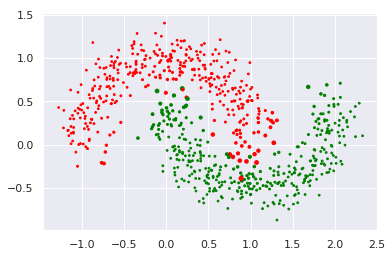

In [0]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap, s=15*(np.abs(y_pred_train - Y_train) + 0.2))
plt.plot()

[]

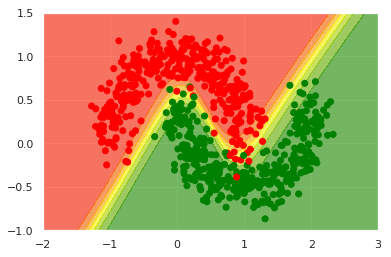

In [0]:
X1 = np.linspace(-2, 3, 100)
X2 = np.linspace(-1, 1.5, 100)

XX1, XX2 = np.meshgrid(X1, X2)
y_pred = np.zeros((XX1.shape))

for i in range(X2.size):
  for j in range(X1.size):
    y_pred[i, j] = ffssn.predict(np.asarray([X1[j], X2[i]]).reshape(1, -1))

plt.contourf(XX1, XX2, y_pred, cmap=my_cmap, alpha=0.6)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
plt.plot()

## Circles Dataset

In [0]:
data_circles, Y_circles = make_circles(n_samples=1000, noise=0.05, random_state=0)
print(data_circles.shape, Y_circles.shape)

(1000, 2) (1000,)


[]

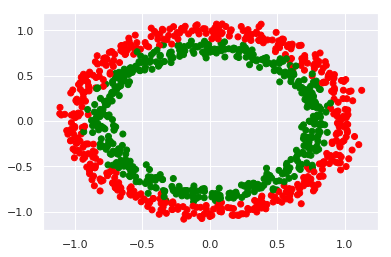

In [0]:
plt.scatter(data_circles[:,0], data_circles[:,1], c=Y_circles, cmap=my_cmap)
plt.plot()

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data_circles, Y_circles, stratify=Y_circles)
print(X_train.shape, X_val.shape)

(750, 2) (250, 2)


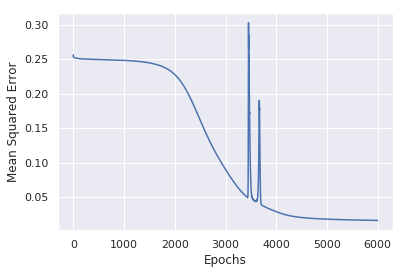

In [0]:
ffssn = FFSNNetwork(2, [8,8])
ffssn.fit(X_train, Y_train, 6000, 0.001, True, True)

In [0]:
y_pred_train = ffssn.predict(X_train)
y_pred_train_binarised = (y_pred_train >= 0.5)
y_pred_val = ffssn.predict(X_val)
y_pred_val_binarised = (y_pred_val >= 0.5)

print('Training Accuracy: ', accuracy_score(y_pred_train_binarised, Y_train))
print('Validation Accuracy: ', accuracy_score(y_pred_val_binarised, Y_val))

Training Accuracy:  0.9786666666666667
Validation Accuracy:  0.96


[]

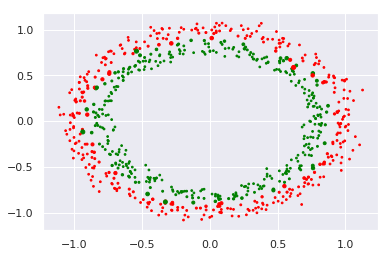

In [0]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap, s=15*(np.abs(y_pred_train - Y_train) + 0.2))
plt.plot()

[]

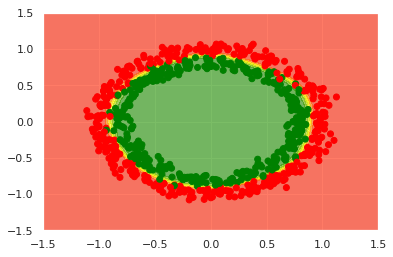

In [0]:
X1 = np.linspace(-1.5, 1.5, 100)
X2 = np.linspace(-1.5, 1.5, 100)

XX1, XX2 = np.meshgrid(X1, X2)
y_pred = np.zeros((XX1.shape))

for i in range(X2.size):
  for j in range(X1.size):
    y_pred[i, j] = ffssn.predict(np.asarray([X1[j], X2[i]]).reshape(1, -1))

plt.contourf(XX1, XX2, y_pred, cmap=my_cmap, alpha=0.6)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
plt.plot()

# Exercise for Backprop

In [0]:
class FFNetworkEx:

  def __init__(self):
    self.w1 = np.random.randn()
    self.w2 = np.random.randn()
    self.w3 = np.random.randn()
    self.w4 = np.random.randn()
    self.w5 = np.random.randn()
    self.w6 = np.random.randn()
    self.w7 = np.random.randn()
    self.w8 = np.random.randn()
    self.w9 = np.random.randn()
    self.w10 = np.random.randn()
    self.b1 = 0
    self.b2 = 0
    self.b3 = 0
    self.b4 = 0
    self.b5 = 0

  def sigmoid(self, x):
    return 1/(1 + np.exp(-x))

  def cross_entropy(self, label, pred):
    y1 = np.multiply(label, pred)
    y1 = y1[y1!=0]
    y1 = -np.log(y1)
    y1 = np.mean(y1)
    return y1
  
  def forward_pass(self, x):
    self.x1, self.x2 = x
    self.a1 = self.w1*self.x1 + self.w2*self.x2 + self.b1
    self.h1 = self.sigmoid(self.a1)
    self.a2 = self.w3*self.x1 + self.w4*self.x2 + self.b2
    self.h2 = self.sigmoid(self.a2)
    self.a3 = self.w5*self.h1 + self.w6*self.h2 + self.b3
    self.h3 = self.sigmoid(self.a3)
    self.a4 = self.w7*self.h1 + self.w8*self.h2 + self.b4
    self.h4 = self.sigmoid(self.a4)
    self.a5 = self.w9*self.h3 + self.w10*self.h4 + self.b5
    self.h5 = self.sigmoid(self.a5)
    return self.h5

  def grad(self,x,y):
    self.forward_pass(x)

    self.da5 = (self.h5 - y) # 1 is replaced by 1
    self.dw9 = self.da5*self.h3
    self.dw10 = self.da5*self.h4
    self.db5 = self.da5*1
    
    self.da3 = self.da5*self.w9*self.h3*(1-self.h3)
    self.da4 = self.da5*self.w10*self.h4*(1-self.h4)
    self.dw5 = self.da3*self.h1
    self.dw6 = self.da3*self.h2
    self.dw7 = self.da4*self.h1
    self.dw8 = self.da4*self.h2
    self.db3 = self.da3*1
    self.db4 = self.da3*1

    self.da1 = (self.da3*self.w5 + self.da4*self.w7)*self.h1*(1-self.h1)
    self.da2 = (self.da3*self.w6 + self.da4*self.w8)*self.h2*(1-self.h2)
    self.dw1 = self.da1*self.x1
    self.dw2 = self.da1*self.x2
    self.dw3 = self.da2*self.x1
    self.dw4 = self.da2*self.x2
    self.db1 = self.da1*1
    self.db2 = self.da2*1

  def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss=False, display_weights=True):

    if initialize:
      self.w1 = np.random.randn()
      self.w2 = np.random.randn()
      self.w3 = np.random.randn()
      self.w4 = np.random.randn()
      self.w5 = np.random.randn()
      self.w6 = np.random.randn()
      self.w7 = np.random.randn()
      self.w8 = np.random.randn()
      self.w9 = np.random.randn()
      self.w10 = np.random.randn()
      self.b1 = 0
      self.b2 = 0
      self.b3 = 0
      self.b4 = 0
      self.b5 = 0
    
    if display_loss:
      loss = {}
    
    if display_weights:
      weights = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      dw1, dw2, dw3, dw4, dw5, dw6, dw7, dw8, dw9, dw10, db1, db2, db3, db4, db5 = [0]*15
      for x,y in zip(X,Y):
        self.grad(x,y)
        dw1 += self.dw1
        dw2 += self.dw2
        dw3 += self.dw3
        dw4 += self.dw4
        dw5 += self.dw5
        dw6 += self.dw6
        dw7 += self.dw7
        dw8 += self.dw8
        dw9 += self.dw9
        dw10 += self.dw10
        db1 += self.db1
        db2 += self.db2
        db3 += self.db3
        db4 += self.db4
        db5 += self.db5
      
      m = X.shape[0]
      self.w1 -= learning_rate*dw1/m
      self.w2 -= learning_rate*dw2/m
      self.w3 -= learning_rate*dw3/m
      self.w4 -= learning_rate*dw4/m
      self.w5 -= learning_rate*dw5/m
      self.w6 -= learning_rate*dw6/m
      self.w7 -= learning_rate*dw7/m
      self.w8 -= learning_rate*dw8/m
      self.w9 -= learning_rate*dw9/m
      self.w10 -= learning_rate*dw10/m
      self.b1 -= learning_rate*db1/m
      self.b2 -= learning_rate*db2/m
      self.b3 -= learning_rate*db3/m
      self.b4 -= learning_rate*db4/m
      self.b5 -= learning_rate*db5/m

      if display_loss:
        Y_pred = self.predict(X)
        # loss[i] = mean_squared_error(Y_pred, Y)
        loss[i] = self.cross_entropy(Y_pred, Y)
      
      if display_weights:
        weights= np.asarray([[0, self.b5, self.w9, self.w10, 0, 0], [self.b3, self.w5, self.w6, self.w7, self.w8, self.b4], [self.b1, self.w1, self.w2, self.w3, self.w4, self.b2]])
        weight_matrices.append(weights)

    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()

  def predict(self, X):
    y_pred = []
    for x in X:
      y_pred.append(self.forward_pass(x))
    return np.asarray(y_pred)
  
  def predict_h1(self, X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.h1)
    return np.asarray(y_pred)
  
  def predict_h2(self, X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.h2)
    return np.asarray(y_pred)
  
  def predict_h3(self, X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.h3)
    return np.asarray(y_pred)
  
  def predict_h4(self, X):
    y_pred = []
    for x in X:
      self.forward_pass(x)
      y_pred.append(self.h4)
    return np.asarray(y_pred)

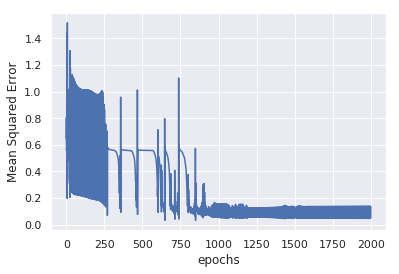

In [0]:
ffn = FFNetworkEx()
ffn.fit(X_train, Y_train, 2000, 5.5, True, True, False)

In [0]:
y_pred_train = ffn.predict(X_train)
y_pred_train_binarised = (y_pred_train >= 0.5)
y_pred_val = ffn.predict(X_val)
y_pred_val_binarised = (y_pred_val >= 0.5)

print('Training Accuracy: ', accuracy_score(y_pred_train_binarised,  Y_train))
print('Validation Accuracy: ', accuracy_score(y_pred_val_binarised,  Y_val))


Training Accuracy:  0.9693333333333334
Validation Accuracy:  0.944


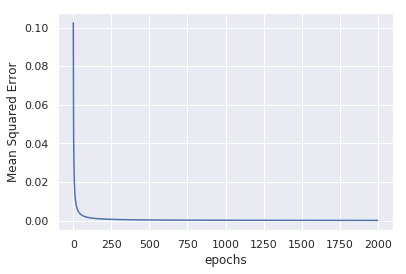

In [0]:
ffn = FFNetworkEx()
ffn.fit(X_train, Y_train, 2000, 5, True, True, False)

In [0]:
y_pred_train = ffn.predict(X_train)
y_pred_train_binarised = (y_pred_train >= 0.5)
y_pred_val = ffn.predict(X_val)
y_pred_val_binarised = (y_pred_val >= 0.5)

print('Training Accuracy: ', accuracy_score(y_pred_train_binarised,  Y_train))
print('Validation Accuracy: ', accuracy_score(y_pred_val_binarised,  Y_val))

Training Accuracy:  0.5
Validation Accuracy:  0.5


In [0]:
!cat /proc/meminfo